# Setup

In [ ]:
from pyspark import SparkContext
import matplotlib.pyplot as plt
import pandas as pd

sc = SparkContext('local', 'BasketAnalysis')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Path to input file and output folder

In [ ]:
path_to_file = "/content/drive/MyDrive/MMDS/baskets.csv"
path_to_output_folder = "/content/drive/MyDrive/MMDS/output"

# Load Dataset

In [ ]:
df = pd.read_csv(path_to_file)
df.head(10)

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1249,01/01/2014,citrus fruit,2014,1,1,2
1,1249,01/01/2014,coffee,2014,1,1,2
2,1381,01/01/2014,curd,2014,1,1,2
3,1381,01/01/2014,soda,2014,1,1,2
4,1440,01/01/2014,other vegetables,2014,1,1,2
5,1440,01/01/2014,yogurt,2014,1,1,2
6,1659,01/01/2014,specialty chocolate,2014,1,1,2
7,1659,01/01/2014,frozen vegetables,2014,1,1,2
8,1789,01/01/2014,hamburger meat,2014,1,1,2
9,1789,01/01/2014,candles,2014,1,1,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
 3   year             38765 non-null  int64 
 4   month            38765 non-null  int64 
 5   day              38765 non-null  int64 
 6   day_of_week      38765 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.1+ MB


# Preprocessing dataset

Check if any column contains null values.

In [ ]:
print(df[df.isnull().any(axis=1)])

Empty DataFrame
Columns: [Member_number, Date, itemDescription, year, month, day, day_of_week]
Index: []


Check if any column contains missing values.

In [ ]:
print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [Member_number, Date, itemDescription, year, month, day, day_of_week]
Index: []


Drop row duplicates

In [ ]:
df = df.drop_duplicates()

# BasketAnalysis Class

In [ ]:
class BasketAnalysis:
    def __init__(self, path_to_output_folder):
        """
        Khởi tạo đối tượng với thư mục lưu trữ đầu ra và SparkContext.

        Parameters:
        - path_to_output_folder (str): Đường dẫn tới thư mục đầu ra.
        """

        self.path_to_output_folder = path_to_output_folder
        self.sc = SparkContext.getOrCreate()

    def load_data(self, path_to_file):
        """
        Tải dữ liệu từ file, bỏ qua dòng tiêu đề và trả về RDD chứa dữ liệu.

        Parameters:
        - path_to_file (str): Đường dẫn tới file dữ liệu đầu vào.

        Returns:
        - RDD: RDD dữ liệu đã loại bỏ dòng tiêu đề.
        """
        rdd = self.sc.textFile(path_to_file)
        if rdd.isEmpty():
            raise ValueError("RDD rỗng! Kiểm tra lại file hoặc đường dẫn.")
        header = rdd.first()
        return rdd.filter(lambda line: line != header)

    def save_to_file(self, rdd, output_file):
        """
        Lưu RDD vào file, gộp thành 1 file duy nhất để dễ dàng đọc.

        Parameters:
        - rdd (RDD): RDD chứa dữ liệu.
        - output_file (str): Đường dẫn tới file đầu ra.
        """
        rdd.map(lambda x: f"{x[0]},{x[1]}") \
           .coalesce(1) \
           .saveAsTextFile(output_file)

    def print_results(self, rdd, num_items):
        """
        Hiển thị kết quả.

        Parameters:
        - rdd (RDD): RDD chứa dữ liệu.
        - num_items (int): Số lượng dòng dữ liệu cần hiển thị.
        """
        results = rdd.take(num_items)
        for item in results:
            print(f"{item[0]}: {item[1]}")

    def plot_bar_chart(self, labels, values, title, xlabel, ylabel):
        """
        Vẽ biểu đồ thanh ngang với nhãn và giá trị cho trước.

        Parameters:
        - labels (list): Danh sách nhãn trên trục y.
        - values (list): Danh sách giá trị trên trục x.
        - title (str): Tiêu đề biểu đồ.
        - xlabel (str): Nhãn cho trục x.
        - ylabel (str): Nhãn cho trục y.
        """
        plt.figure(figsize=(20, 15))

        """ Sử dụng bảng màu 'tab20' cho các thanh """
        colors = plt.cm.get_cmap('tab20').colors

        """ Vẽ thanh ngang và thêm nhãn cho giá trị """
        bars = plt.barh(labels, values, color=[colors[i % len(colors)]
                                               for i in range(len(values))])
        for bar in bars:
            width = bar.get_width()
            plt.text(width, bar.get_y() + bar.get_height()/2,
                                    f'{int(width)}', va='center', ha='left')

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        """ Đảo ngược trục y để nhãn xếp từ trên xuống """
        plt.gca().invert_yaxis()
        plt.show()

    def f1(self, path_to_file):
        """
        Tìm ra danh sách món hàng phân biệt, số lần mỗi món hàng được mua.

        Parameters:
        - path_to_file (str): Đường dẫn tới file dữ liệu.
        """
        data_rdd = self.load_data(path_to_file)

        """ Tính số lần mua của từng mặt hàng """
        item_counts = data_rdd.map(lambda x: x.split(",")[2].strip()) \
                              .map(lambda item: (item, 1)) \
                              .reduceByKey(lambda a, b: a + b) \
                              .sortBy(lambda x: x[1], ascending=False)

        """ Lưu kết quả và hiển thị """
        output_file = f"{self.path_to_output_folder}/f1/"
        self.save_to_file(item_counts, output_file)
        self.print_results(item_counts, 20)

        """ Vẽ biểu đồ top 100 mặt hàng """
        top_100_items = item_counts.take(100)
        items, counts = zip(*top_100_items)
        self.plot_bar_chart(items, counts,
                'Top 100 món hàng được mua nhiều nhất',
                'Số lần mua', 'Món hàng')

    def f2(self, path_to_file):
        """
        Tìm ra số lượng giỏ hàng mà mỗi người dùng đã mua.
        Một giỏ hàng là tập hợp các món hàng mà mỗi người dùng
        mua trong một ngày (date).

        Parameters:
        - path_to_file (str): Đường dẫn tới file dữ liệu.
        """
        data_rdd = self.load_data(path_to_file)

        """ Tính số lượng giỏ hàng của mỗi người dùng """
        basket_rdd = data_rdd.map(lambda x: (x.split(",")[0].strip(),
                                             x.split(",")[1].strip()))
        user_baskets = basket_rdd.distinct() \
                                 .map(lambda x: (x[0], 1)) \
                                 .reduceByKey(lambda a, b: a + b) \
                                 .sortBy(lambda x: x[1], ascending=False)

        self.print_results(user_baskets, 20)

        """ Lưu kết quả và vẽ biểu đồ top 100 người dùng """
        output_file = f"{self.path_to_output_folder}/f2/"
        self.save_to_file(user_baskets, output_file)
        top_100_users = user_baskets.take(100)
        users, basket_counts = zip(*top_100_users)
        self.plot_bar_chart(users, basket_counts,
        'Top 100 người dùng mua nhiều giỏ hàng nhất',
                            'Số giỏ hàng', 'Người dùng')

    def f3(self, path_to_file, item_name):
        """
        Thống kê số lần món hàng được mua (giỏ hàng) theo từng tháng.

        Parameters:
        - path_to_file (str): Đường dẫn tới file dữ liệu.
        - item_name (str): Tên món hàng cần phân tích.
        """
        data_rdd = self.load_data(path_to_file)

        """ Lọc item_name trong bộ dữ liệu """
        item_rdd = data_rdd.filter(lambda x: x.split(",")[2].strip() == item_name)
        if item_rdd.isEmpty():
            print(f"Không tìm thấy món hàng '{item_name}' trong dữ liệu.")
            return

        """ Tính số lần mua của item theo tháng """
        item_month_rdd = item_rdd.map(lambda x: (x.split(",")[4].strip(), 1))
        item_month_count = item_month_rdd.reduceByKey(lambda a, b: a + b) \
                                     .sortBy(lambda x: int(x[0]))

        self.print_results(item_month_count, item_month_count.count())

        """ Lưu và vẽ biểu đồ """
        output_file = f"{self.path_to_output_folder}/f3"
        self.save_to_file(item_month_count, output_file)
        data_to_plot = list(item_month_count.toLocalIterator())
        months, counts = zip(*data_to_plot)
        self.plot_bar_chart(months, counts, f'Số lần mua {item_name} theo tháng', 'Số lần mua', 'Tháng')

    def f4(self, path_to_file, customer_id):
        """
        Phân tích số lần mua hàng của một khách hàng cụ thể theo tháng, lưu kết quả và vẽ biểu đồ.

        Parameters:
        - path_to_file (str): Đường dẫn tới file dữ liệu.
        - customer_id (str): Mã khách hàng cần phân tích.
        """
        data_rdd = self.load_data(path_to_file)

        """ Lọc các customer_id trong bộ dữ liệu """
        customer_rdd = data_rdd.filter(lambda x: x.split(",")[0].strip() == customer_id)
        if customer_rdd.isEmpty():
            print(f"Không tìm thấy khách hàng với mã '{customer_id}' trong dữ liệu.")
            return

        """ Tính số lần mua hàng của khách hàng theo tháng """
        customer_month_rdd = customer_rdd.map(lambda x: (x.split(",")[4].strip(), 1))
        customer_month_count = customer_month_rdd.reduceByKey(lambda a, b: a + b) \
                                             .sortBy(lambda x: int(x[0]))

        self.print_results(customer_month_count, customer_month_count.count())

        """ Lưu và vẽ biểu đồ """
        output_file = f"{self.path_to_output_folder}/f4"
        self.save_to_file(customer_month_count, output_file)
        data_to_plot = list(customer_month_count.toLocalIterator())
        months, counts = zip(*data_to_plot)
        self.plot_bar_chart(months, counts,
                    f'Số lần mua hàng của khách {customer_id} theo tháng',
                    'Số lần mua', 'Tháng')


# Test

Khởi tạo đối tượng

In [ ]:
analysis = BasketAnalysis(path_to_output_folder)

Test và xem kết quả hàm f1

whole milk: 2502
other vegetables: 1898
rolls/buns: 1716
soda: 1514
yogurt: 1334
root vegetables: 1071
tropical fruit: 1032
bottled water: 933
sausage: 924
citrus fruit: 812
pastry: 785
pip fruit: 744
shopping bags: 731
canned beer: 717
bottled beer: 687
whipped/sour cream: 662
newspapers: 596
frankfurter: 580
brown bread: 571
domestic eggs: 566


<ipython-input-26-0a676f1a175d>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20').colors


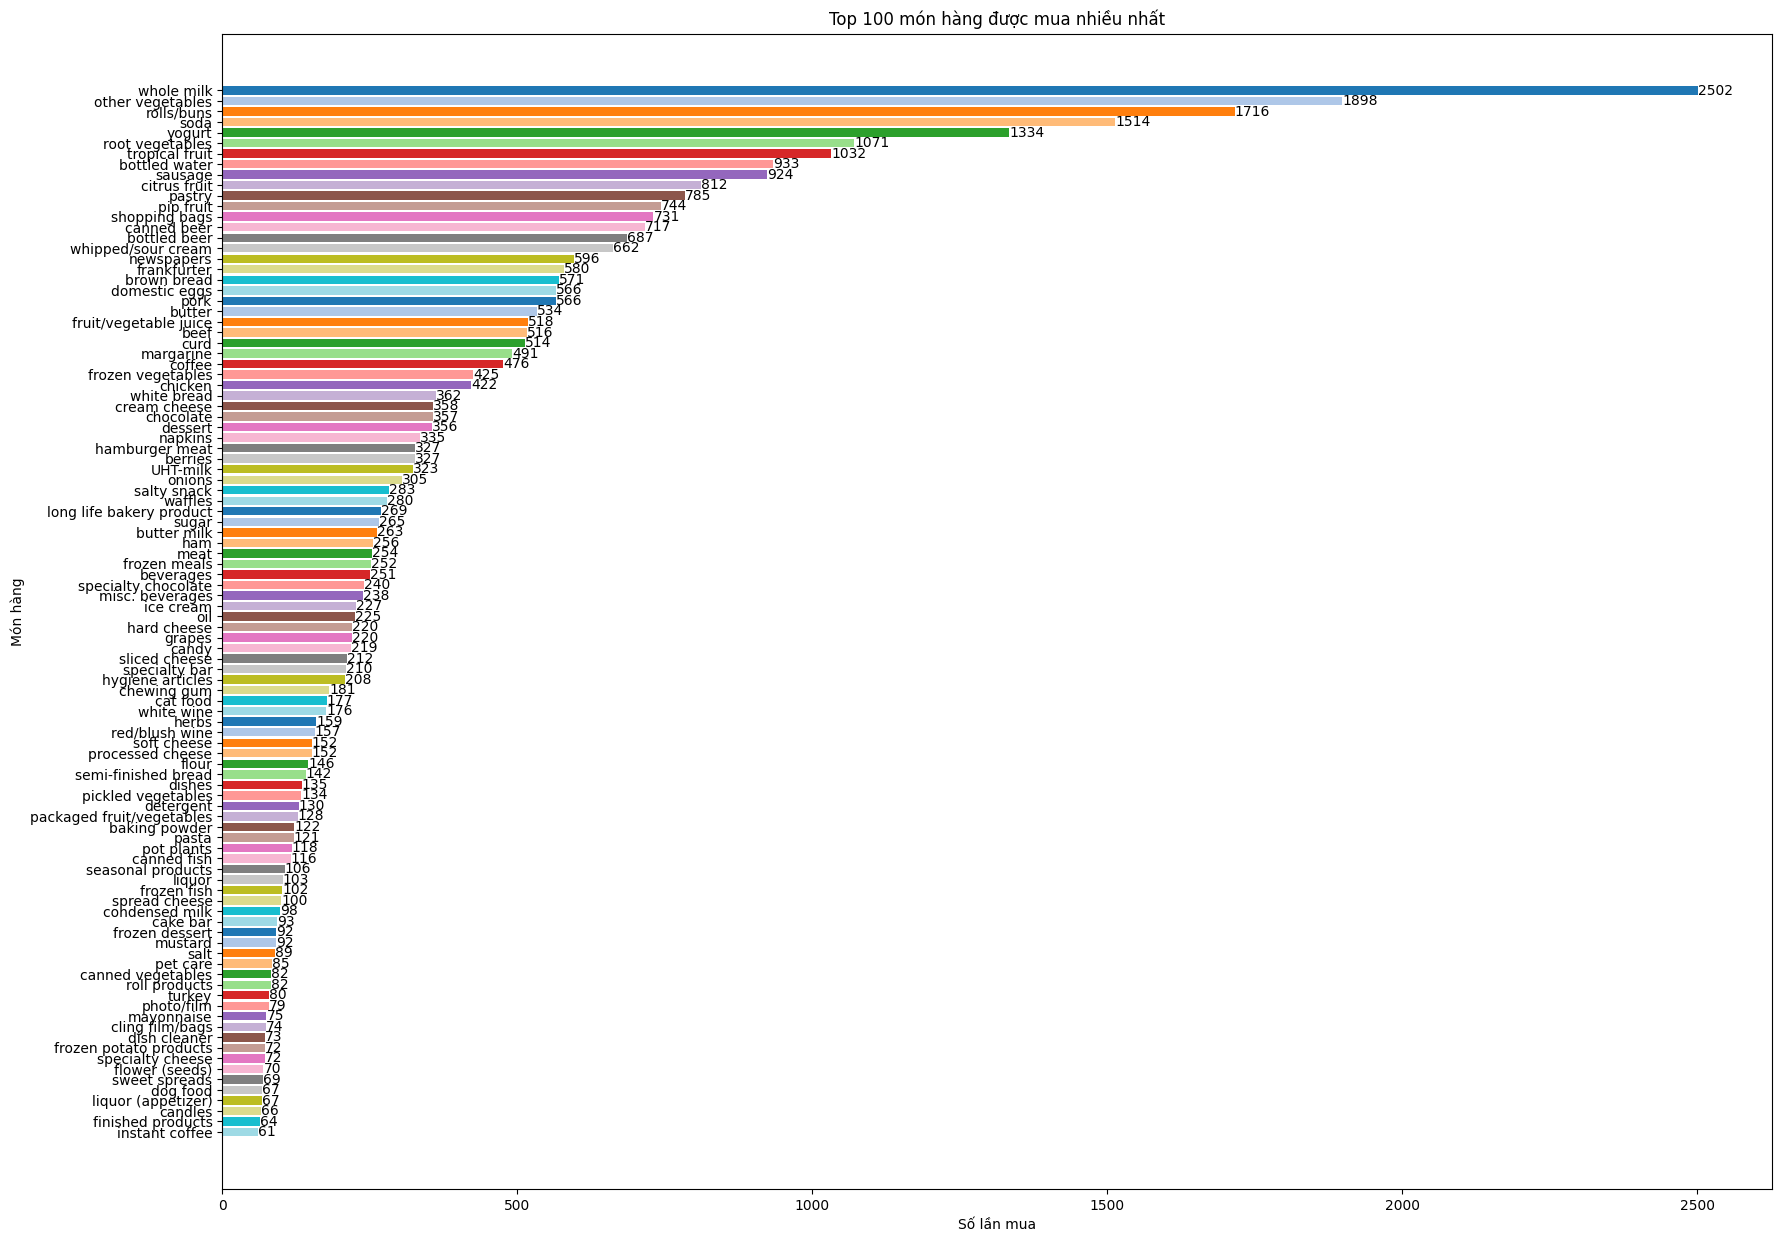

In [ ]:
analysis.f1(path_to_file)

Test và xem kết quả hàm f2

1379: 11
3737: 11
2271: 11
4338: 11
2193: 11
4376: 10
1052: 10
1574: 10
1275: 10
1908: 10
3289: 10
3120: 10
3180: 10
2394: 10
4217: 10
2524: 10
4864: 10
3872: 10
3484: 10
3082: 10


<ipython-input-26-0a676f1a175d>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20').colors


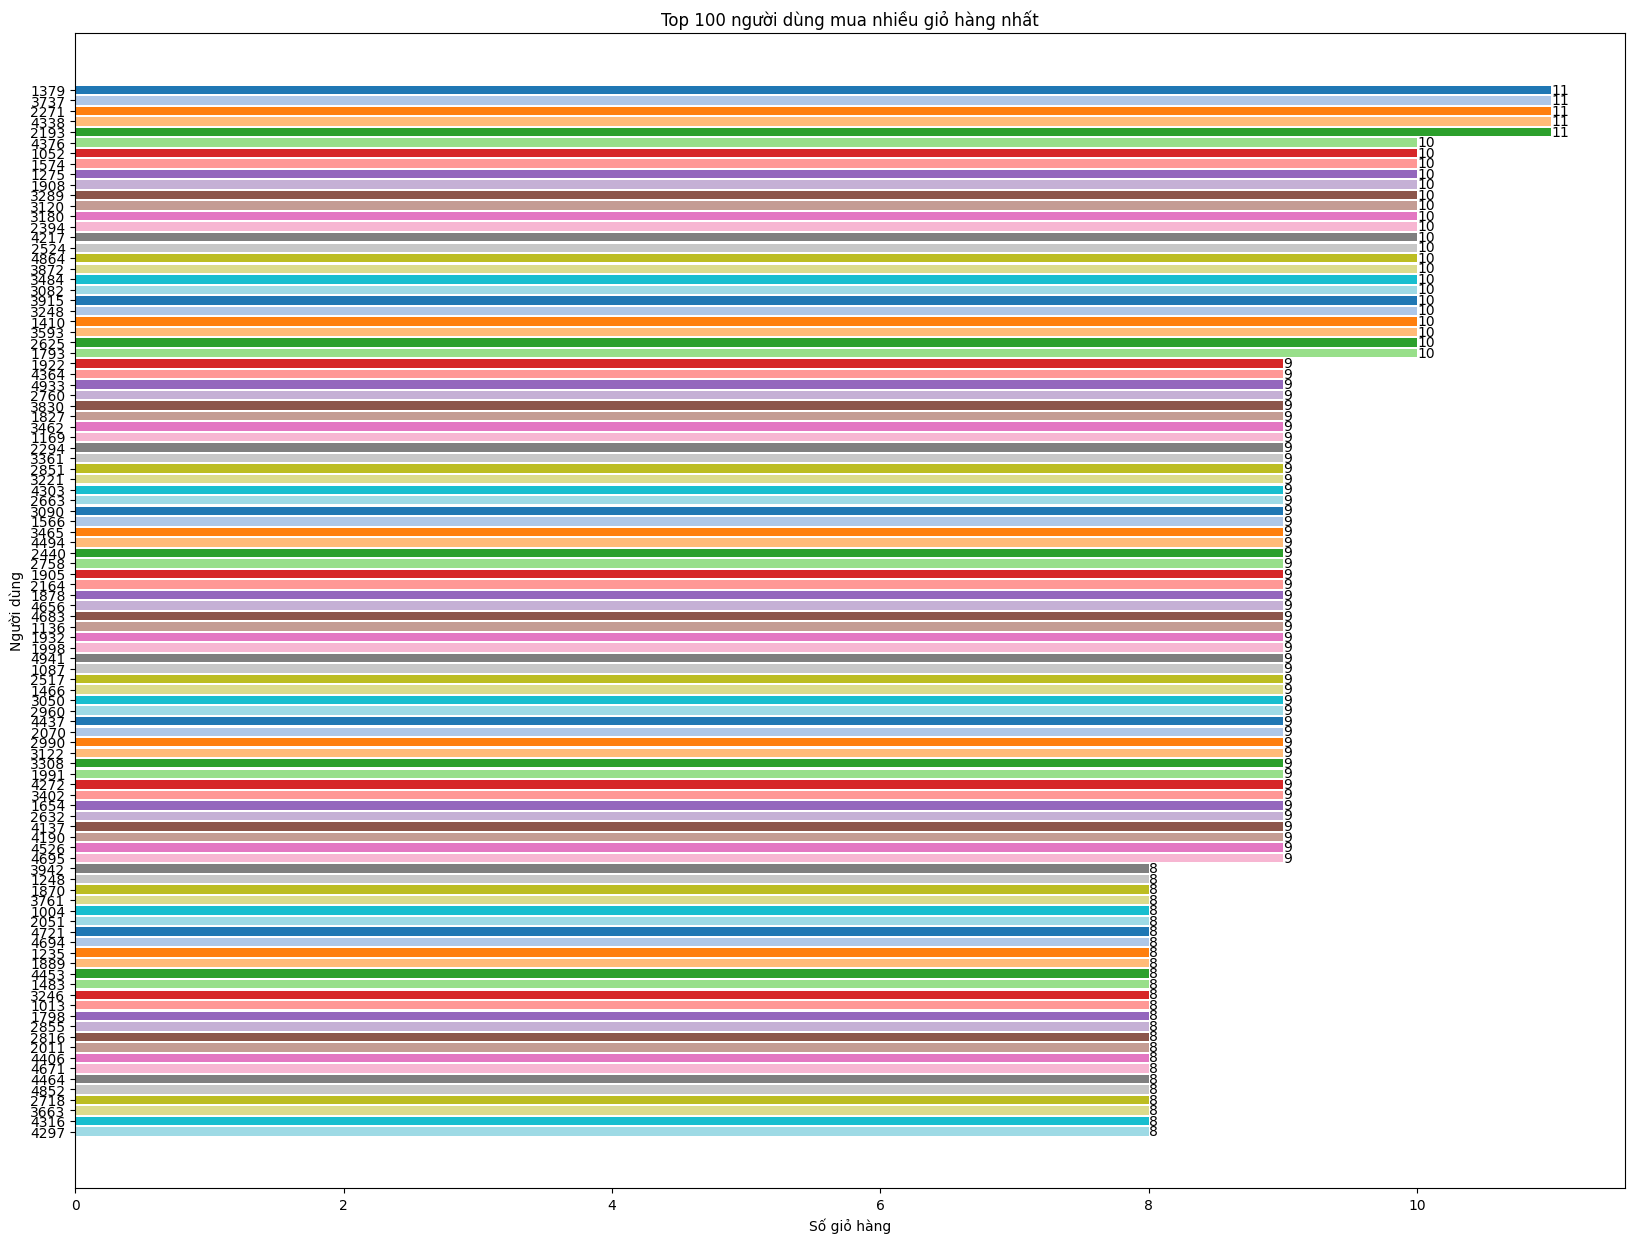

In [ ]:
analysis.f2(path_to_file)

Test và xem kết quả hàm f3

1: 7
2: 4
3: 6
4: 8
5: 4
6: 8
7: 6
8: 5
9: 3
10: 10
11: 8
12: 4


<ipython-input-26-0a676f1a175d>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20').colors


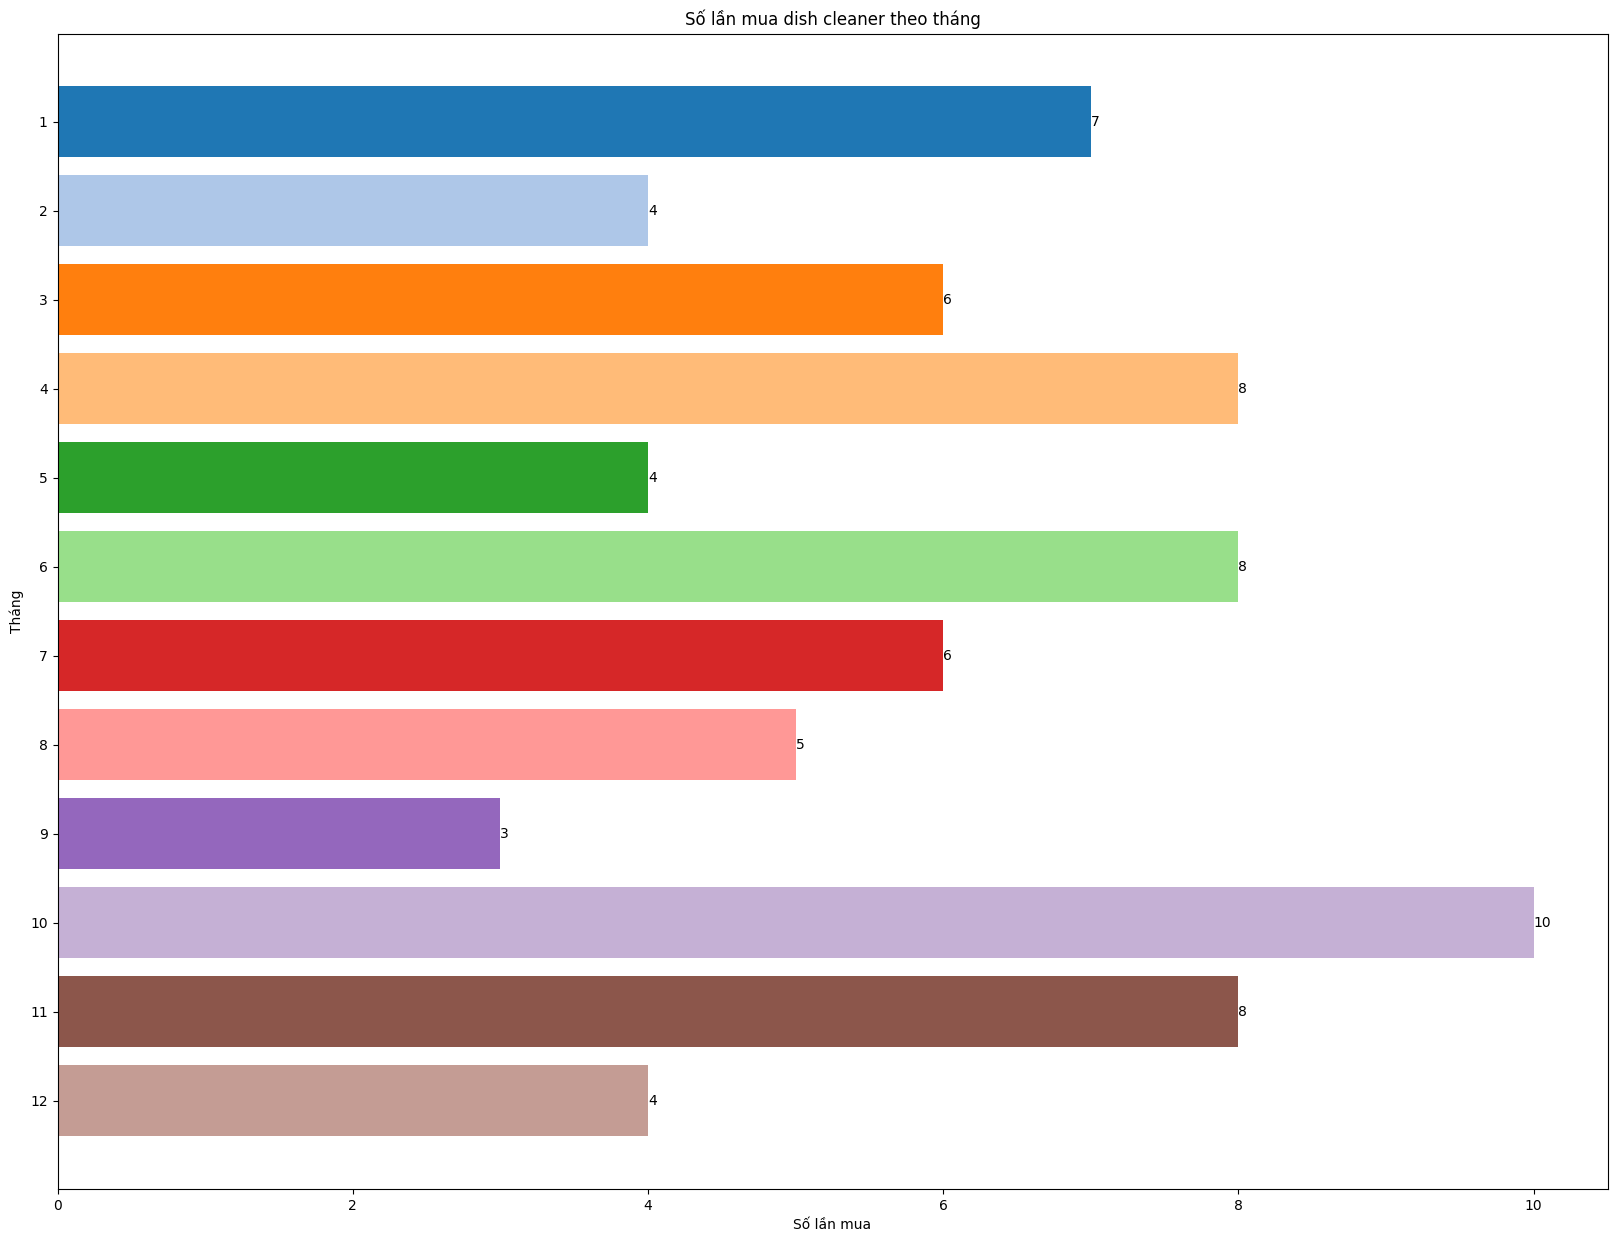

In [ ]:
item_name = "dish cleaner"
analysis.f3(path_to_file, item_name)

Test và xem kết quả hàm f4

3: 2
4: 3
7: 2


<ipython-input-26-0a676f1a175d>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20').colors


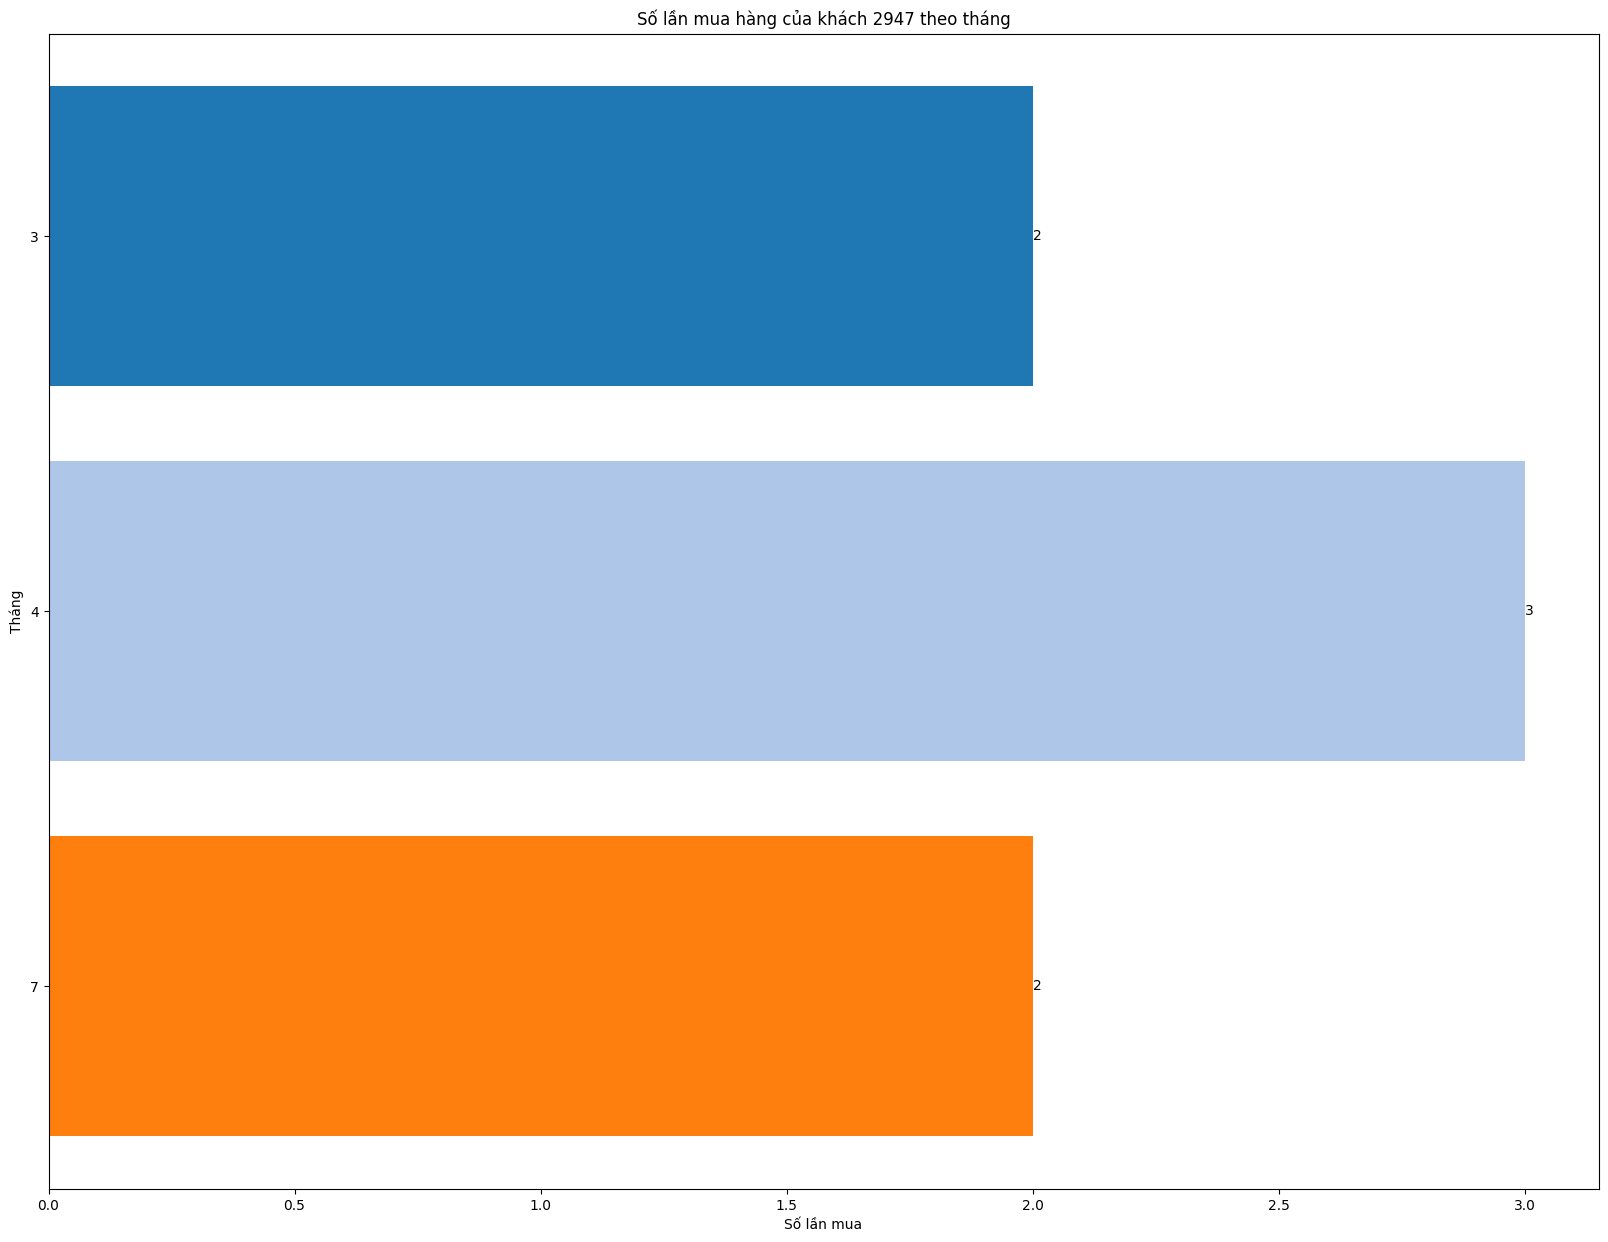

In [ ]:
customer_id = "2947"
analysis.f4(path_to_file, customer_id)